In [115]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV

%matplotlib inline
RSEED = 50

## Load Original Features

In [116]:
df_total = pd.read_csv('./data/features375.csv')

In [117]:
features_train = df_total[df_total['isFraud'].notnull()]
features_test = df_total[df_total['isFraud'].isnull()]

In [118]:
labels_train = features_train['isFraud']
features_train = features_train.drop(columns = ['isFraud', 'TransactionID'])

In [119]:
features_train.shape

(590540, 373)

# Prepare Model

In [120]:
categorical = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5','card6',
              'addr1','addr2','P_emaildomain','R_emaildomain','M1','M2','M3',
              'M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','dow','hour',
              'card_id']
ids = [ 'id_%s'%(i) for i in range(12,39)]
categorical = categorical + ids
categorical = list(set(categorical).intersection(df_total.columns))

In [121]:
# Create a  lgb training set
train_set = lgb.Dataset(features_train, label = labels_train.values,
                        categorical_feature=categorical,free_raw_data=False)

In [122]:
model = lgb.LGBMClassifier(scale_pos_weight=9)
params = model.get_params()

In [123]:
cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc',
                        early_stopping_rounds = 100, seed = RSEED, nfold = 5)
print('Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results['auc-mean'][-1],
                                                                               cv_results['auc-stdv'][-1]))


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Cross Validation ROC AUC: 0.92792 with std: 0.00206.


In [124]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), random_state=RSEED,scale_pos_weight=9)
model.fit(features_train, labels_train.values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=50, reg_alpha=0.0, reg_lambda=0.0,
               scale_pos_weight=9, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [48]:
#get_predict(features_test,model,'./data/base_nofselect.csv')

# Feature Selection

In [125]:
fi = pd.DataFrame({'feature': features_train.columns, 
                   'importance': model.feature_importances_})
fi = fi.sort_values('importance', ascending = False)

Text(0.5,1,'LGB Features (avg over folds)')

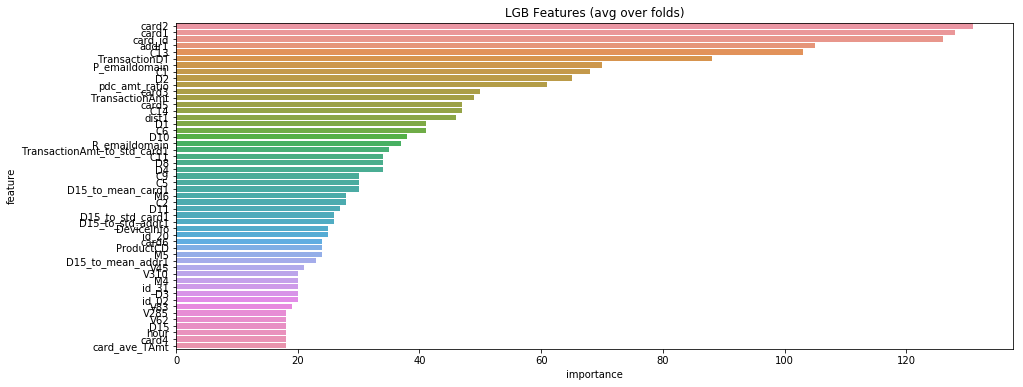

In [129]:
f, ax = plt.subplots(figsize=(15, ))
sns.barplot(x="importance", y="feature", data=fi.iloc[0:50,:])
plt.title('LGB Features (avg over folds)')

In [127]:
fi.head(50)

,feature,importance
4,card2,131
3,card1,128
364,card_id,126
9,addr1,105
25,C13,103
0,TransactionDT,88
12,P_emaildomain,70
14,C1,68
28,D2,65
363,pdc_amt_ratio,61


In [99]:
feat_select = {}

In [100]:
for importance in range(1,11):
    fi_unimportant = fi[fi['importance'] < importance]
    features_train_new = features_train.drop(np.array(fi_unimportant['feature']), axis=1)
    features_test_new = features_test.drop(np.array(fi_unimportant['feature']), axis=1)
    categorical_new = list(np.setdiff1d(categorical,fi_unimportant['feature'].values))
    train_set = lgb.Dataset(features_train_new, label = labels_train.values,
                        categorical_feature = categorical_new)
    model = lgb.LGBMClassifier(scale_pos_weight=9)
    params = model.get_params()
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc', 
                        early_stopping_rounds = 100, seed = RSEED, nfold = 5)
    print('Feature Importance:{:.1f} Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(importance,cv_results['auc-mean'][-1],
                                                                               cv_results['auc-stdv'][-1]))
    feat_select.update( {importance : np.array(fi_unimportant['feature'])} )

    

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Feature Importance:1.0 Cross Validation ROC AUC: 0.92786 with std: 0.00106.


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Feature Importance:2.0 Cross Validation ROC AUC: 0.92832 with std: 0.00106.


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Feature Importance:3.0 Cross Validation ROC AUC: 0.92780 with std: 0.00127.


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Feature Importance:4.0 Cross Validation ROC AUC: 0.92832 with std: 0.00112.


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Feature Importance:5.0 Cross Validation ROC AUC: 0.92870 with std: 0.00076.


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Feature Importance:6.0 Cross Validation ROC AUC: 0.92803 with std: 0.00181.


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Feature Importance:7.0 Cross Validation ROC AUC: 0.92876 with std: 0.00194.


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Feature Importance:8.0 Cross Validation ROC AUC: 0.92939 with std: 0.00124.


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Feature Importance:9.0 Cross Validation ROC AUC: 0.92937 with std: 0.00140.


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Feature Importance:10.0 Cross Validation ROC AUC: 0.92859 with std: 0.00127.


In [101]:
features_train_new.shape

(590540, 68)

In [102]:
features_test_new.shape

(506691, 70)

In [15]:
feat_select[10]

array(['id_05', 'V312', 'V296', 'V317', 'V189', 'V152', 'V48', 'V49',
       'V61', 'V67', 'V293', 'C8', 'V13', 'V294', 'id_07', 'V149', 'V131',
       'id_04', 'V20', 'V35', 'V283', 'V75', 'V94', 'V96', 'M9', 'D6',
       'id_13', 'V136', 'V81', 'id_03', 'dist2', 'V2', 'id_33', 'C10',
       'V217', 'V338', 'V291', 'V169', 'V36', 'V320', 'V37', 'V339',
       'V162', 'V19', 'V139', 'V187', 'V180', 'D12', 'id_32', 'V271',
       'V261', 'V126', 'V335', 'V91', 'dow', 'V78', 'D14', 'V24', 'V66',
       'V5', 'V30', 'V74', 'V309', 'V206', 'V311', 'id_21', 'V52', 'V4',
       'id_18', 'V115', 'V297', 'V102', 'V308', 'V215', 'V146', 'V127',
       'V128', 'V129', 'V220', 'V323', 'V224', 'V256', 'V336', 'V201',
       'V64', 'V326', 'V70', 'V264', 'V90', 'C4', 'V203', 'V133', 'V99',
       'V33', 'V208', 'V175', 'V318', 'V23', 'V178', 'V25', 'V11', 'V143',
       'V12', 'V145', 'V276', 'V166', 'V200', 'V172', 'V171', 'V205',
       'V135', 'V160', 'V46', 'V47', 'C7', 'V157', 'V164', 'V44', '

In [103]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), 
                           random_state=RSEED,scale_pos_weight=9)
model.fit(features_train_new, labels_train.values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=50, reg_alpha=0.0, reg_lambda=0.0,
               scale_pos_weight=9, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [105]:
get_predict(features_test_new,model,'./data/sub_feat439_notune.csv')

# Parameter tunning

## max bin and min_data_in_leaf

In [82]:
params_test1={
    'max_bin': range(5,256,20),
    'min_data_in_leaf':range(1,102,20)
}


gsearch1 = GridSearchCV(estimator=model, param_grid=params_test1, scoring='roc_auc', cv=5, verbose=1, n_jobs=10)

In [83]:
gsearch1.fit(features_train_new, labels_train.values)

Fitting 5 folds for each of 78 candidates, totalling 390 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  8.6min
[Parallel(n_jobs=10)]: Done 390 out of 390 | elapsed: 18.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=50, reg_alpha=0.0,
                                      reg_lambda=0.0, scale_pos_weight=9,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=10,
             param_grid={'max_

In [84]:
gsearch1.best_params_

{'max_bin': 5, 'min_data_in_leaf': 61}

In [85]:
gsearch1.best_score_

0.9026615616245327

## feature_fraction、bagging_fraction、bagging_freq

In [35]:
params_test2={'feature_fraction': [0.6,0.8,1.0],
              'bagging_fraction': [0.6,0.8,1.0],
              'bagging_freq': range(0,81,20)
}

In [36]:
gsearch2 = GridSearchCV(estimator=lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), 
                                                     random_state=RSEED,scale_pos_weight=9,
                                                     max_bin=5,min_data_in_leaf=21), 
                        param_grid=params_test2, scoring='roc_auc', cv=5, verbose=1, n_jobs=4)

In [37]:
gsearch2.fit(features_train_new, labels_train.values)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 15.6min
[Parallel(n_jobs=4)]: Done 225 out of 225 | elapsed: 18.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_bin=5,
                                      max_depth=-1, min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_data_in_leaf=21, min_split_gain=0.0,
                                      n_estimators=100, n_jobs=-1,
                                      num_leaves=31, objective=None,
                                      random_state=50, reg_alpha=0.0,
                                      reg_lambda=0.0, scale_pos_weight=9,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=

In [39]:
gsearch2.best_params_

{'bagging_fraction': 0.8, 'bagging_freq': 80, 'feature_fraction': 1.0}

In [40]:
gsearch2.best_score_

0.901302819815827

## lambda_l1 and lambda_l2

In [19]:
params_test3={'lambda_l1': [1e-5,1e-1,0.1,0.5,0.9,1.0],
              'lambda_l2': [1e-5,1e-1,0.1,0.5,0.9,1.0]
}

In [20]:
gsearch3 = GridSearchCV(estimator=lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), 
                                                     random_state=RSEED,scale_pos_weight=9), 
                        param_grid=params_test3, scoring='roc_auc', cv=5, verbose=1, n_jobs=4)

In [21]:
gsearch3.fit(features_train_new, labels_train.values)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed: 20.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=50, reg_alpha=0.0,
                                      reg_lambda=0.0, scale_pos_weight=9,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=4,
             param_grid={'lambd

In [22]:
gsearch3.best_params_

{'lambda_l1': 1.0, 'lambda_l2': 0.9}

In [23]:
gsearch3.best_score_

0.8778124193138388

## min_split_gain

In [66]:
params_test4={'min_split_gain':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
              
gsearch4 = GridSearchCV(estimator = lgb.LGBMClassifier(scale_pos_weight=9,lambda_l1=1e-05,lambda_l2=0.1) , 
                       param_grid = params_test4, scoring='roc_auc',cv=5,n_jobs=-1)
gsearch4.fit(features_train_new, labels_train.values)
gsearch4.best_params_, gsearch4.best_score_

({'min_split_gain': 0.0}, 0.8810566907217761)

# Final Model

In [86]:
model1 = lgb.LGBMClassifier(scale_pos_weight=9,max_bin=5,min_data_in_leaf=61)
#max_bin=5,min_data_in_leaf=21
#lambda_l1=1e-05,lambda_l2=0.1
#bagging_fraction=0.8,bagging_freq=80,feature_fraction=1,
params = model1.get_params()
train_set = lgb.Dataset(features_train_new, label = labels_train.values,
                        categorical_feature = categorical_new)
cv_results1 = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc', 
                        early_stopping_rounds = 100, seed = RSEED, nfold = 5)
print('Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results1['auc-mean'][-1],
                                                                               cv_results1['auc-stdv'][-1]))

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Cross Validation ROC AUC: 0.92921 with std: 0.00243.


In [32]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results1['auc-mean']), random_state=RSEED,scale_pos_weight=9,lambda_l1=1,lambda_l2=0.9)
model1.fit(features_train_new, labels_train.values)
#model1.booster_.save_model('model1.txt')

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=1, lambda_l2=0.9,
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=9, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# Predict

In [78]:
def get_predict(feature_test,model,fname):
    id_test = feature_test['TransactionID']
    features_test_final = feature_test.drop(columns = ['isFraud', 'TransactionID'])
    preds = model.predict_proba(features_test_final)[:, 1]
    submission = pd.DataFrame({'TransactionID': id_test, 
                                'isFraud': preds})
    submission.to_csv(fname, index = False)

In [28]:
id_test = features_test_new['TransactionID']
# Make predictions on the testing data
features_test_final = features_test_new.drop(columns = ['isFraud', 'TransactionID'])
preds = model1.predict_proba(features_test_final)[:, 1]
submission = pd.DataFrame({'TransactionID': id_test, 
                                'isFraud': preds})
submission.to_csv('./data/sub_baseline_fs.csv', index = False)